# Getting Started

Follow the general instructions from hw1_Q1

In [8]:
# get to the parent dir of mai_dul repo
import os

os.getcwd()

'/home/ordem/PycharmProjects/MAI_DUL_WS24/homeworks/hw1'

In [9]:
# run only once at the beginning of working on hw1
# !unzip -qq data/hw1_data.zip -d data/

# install latest version deepul package
# !pip install -e .

# Question 2 PixelCNNs

Now, we will work with a higher dimensional datasets.
We will start from black-and-white shape dataset and MNIST, in the second part we will extend to modeling colored datasets.

Run the cell below to visualize the two binary datasets.

In [10]:
import numpy as np
from deepul.hw1_helper import (
    # Q2
    q2a_save_results,
    visualize_q2a_data,
)

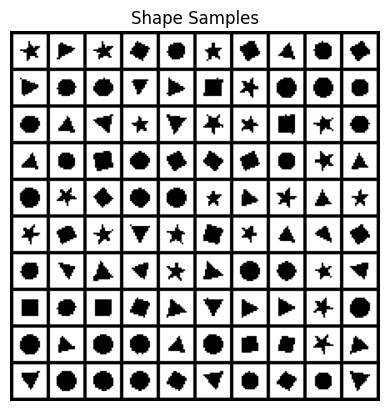

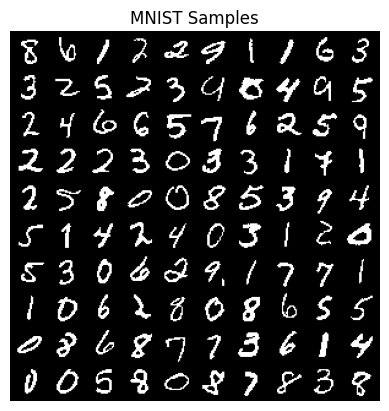

In [11]:
visualize_q2a_data(1)
visualize_q2a_data(2)

## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images.

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

Checkout the Paper for more details: https://arxiv.org/abs/1601.06759

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [12]:
from models.BinaryPixelCNN import BinaryPixelCNN
from torch.optim import Adam
from utils import rescale_tensor
import torch
from torch.utils.data import TensorDataset, DataLoader


def q2_a(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets
    
    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
    """
    batch_size = 64
    learning_rate = 0.001
    max_epochs = 40

    # rescale from 0/1 to -1/+1
    train_dataset = TensorDataset(rescale_tensor(torch.tensor(train_data).permute((0, 3, 1, 2)).float(), (0, 1), (-1,+1)))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    x_test = rescale_tensor((torch.tensor(test_data).permute((0, 3, 1, 2)).float()), (0, 1), (-1, +1))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    x_test = x_test.to(device)

    model = BinaryPixelCNN(filters=64)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    test_losses = []
    for epoch in range(max_epochs):
        batches = iter(train_loader)

        batch_train_loss = np.empty(len(batches))
        for i, [batch_x] in enumerate(batches):
            batch_x = batch_x.to(device)
            logits = model.forward(batch_x)

            loss = model.loss_function(batch_x, logits)
            batch_train_loss[i] = loss

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        train_losses.append(batch_train_loss.mean().item())

        model.eval()
        with torch.no_grad():
            test_logits = model.forward(x_test)
            test_loss = model.loss_function(x_test, test_logits)
            test_losses.append(test_loss.item())
        model.train()
        print(f"epoch {epoch + 1}/{max_epochs}, train loss: {train_losses[-1]}, test loss: {test_losses[-1]}")
    samples = model.generate(100, device).permute((0, 2, 3, 1)).numpy(force=True)
    return train_losses, test_losses, samples

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



In [13]:
q2a_save_results(1, q2_a)

In [14]:
q2a_save_results(2, q2_a)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.87 GiB. GPU 